In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
import sqlite3
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [23]:
database_filepath = "./accident_data_v1.0.0_2023.db"

In [24]:
query = """
    SELECT date, accident_index, police_force
    FROM accident
    WHERE police_force IN (11, 12, 13)
    AND accident_year BETWEEN 2017 AND 2020;
"""

In [25]:
df = None
with sqlite3.connect(database_filepath) as conn:
    df = pd.read_sql_query(query, conn)

df

,date,accident_index,police_force
0,11/01/2017,2017110146070,11
1,01/01/2017,2017110147315,11
2,01/01/2017,2017110147443,11
3,01/01/2017,2017110147559,11
4,02/01/2017,2017110147732,11
...,...,...,...
24364,31/12/2020,2020137CV0566,13
24365,31/12/2020,2020137CV0707,13
24366,31/12/2020,2020137CV0938,13
24367,31/12/2020,2020137CV1840,13


In [26]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df

,date,accident_index,police_force
0,2017-01-11,2017110146070,11
1,2017-01-01,2017110147315,11
2,2017-01-01,2017110147443,11
3,2017-01-01,2017110147559,11
4,2017-01-02,2017110147732,11
...,...,...,...
24364,2020-12-31,2020137CV0566,13
24365,2020-12-31,2020137CV0707,13
24366,2020-12-31,2020137CV0938,13
24367,2020-12-31,2020137CV1840,13


In [27]:
## Set 'date' as index
df.set_index('date', inplace=True)
 
# Aggregate weekly accident counts
weekly_accidents = df.groupby(['police_force']).resample('W').size().unstack(level=0)
 
weekly_accidents = df.resample('W').size().reset_index(name = 'accident_count')
 
# Set 'date' as index
weekly_accidents.set_index('date', inplace=True)
 
# remove last row which represnets first week in 2021
weekly_accidents = weekly_accidents.iloc[1:-1]

# Display DataFrame
weekly_accidents

,accident_count
date,
2017-01-08,116
2017-01-15,140
2017-01-22,141
2017-01-29,139
2017-02-05,158
...,...
2020-11-29,77
2020-12-06,109
2020-12-13,90


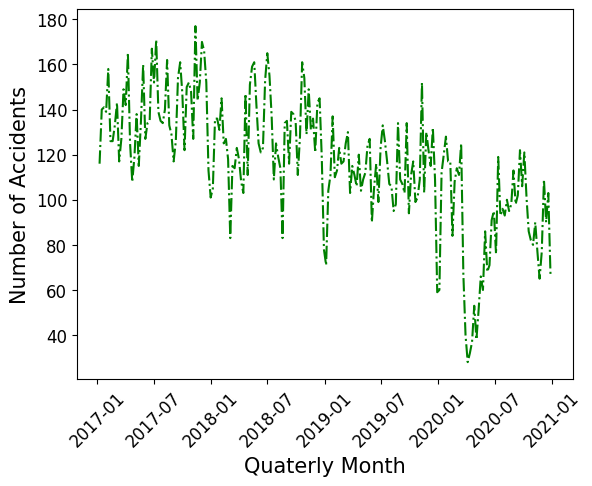

In [28]:
# Visualisation of the data
plt.plot(weekly_accidents.index, weekly_accidents['accident_count'], 'g-.')

# Adding labels and title
plt.xlabel('Quaterly Month', fontsize=15)
plt.ylabel('Number of Accidents', fontsize=15)

# Formatting the ticks on x and y axis
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

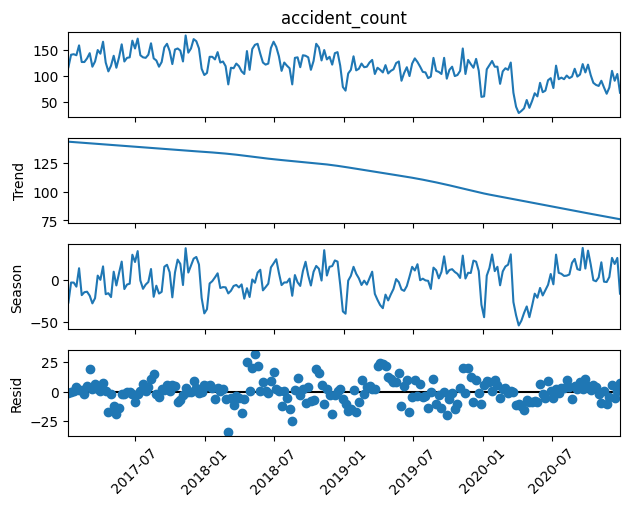

In [29]:
STL(weekly_accidents['accident_count']).fit().plot()
plt.xticks(rotation=45)
plt.show()

In [30]:
# Testing the differenced series for stationarity
ADF_test = adfuller(weekly_accidents)[:2]

print(f"ADF Statistic: {ADF_test[0]}; p-value {ADF_test[1]}")

ADF Statistic: -2.2623026929688526; p-value 0.18441439476655314


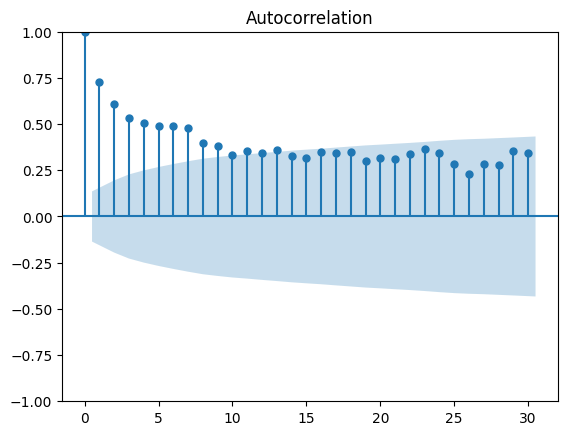

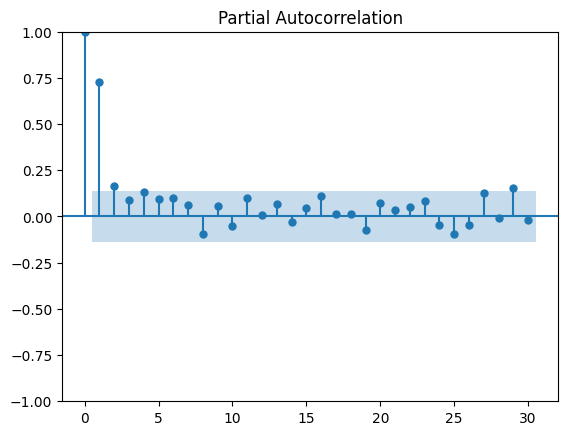

In [31]:
# Plot of ACF to understand the series 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(weekly_accidents, lags=30)
plot_pacf(weekly_accidents, lags=30)
plt.show()

In [32]:
diff_1 = weekly_accidents[['accident_count']].diff(1).dropna()
diff_1

,accident_count
date,
2017-01-15,24.0
2017-01-22,1.0
2017-01-29,-2.0
2017-02-05,19.0
2017-02-12,-32.0
...,...
2020-11-29,12.0
2020-12-06,32.0
2020-12-13,-19.0


In [33]:
adf_test = adfuller(diff_1)[:2]
print(f"ADF Statistic: {adf_test[0]}; p-value {adf_test[1]}")

ADF Statistic: -8.837952545714742; p-value 1.698872201721135e-14


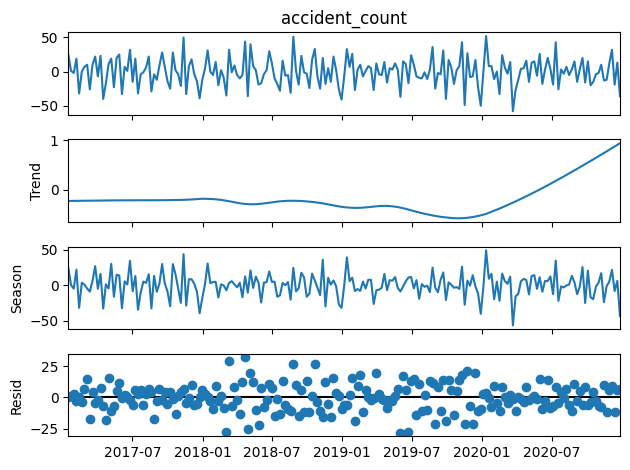

In [34]:
# Decomposition of the differenced series
STL(diff_1['accident_count']).fit().plot()
plt.show()

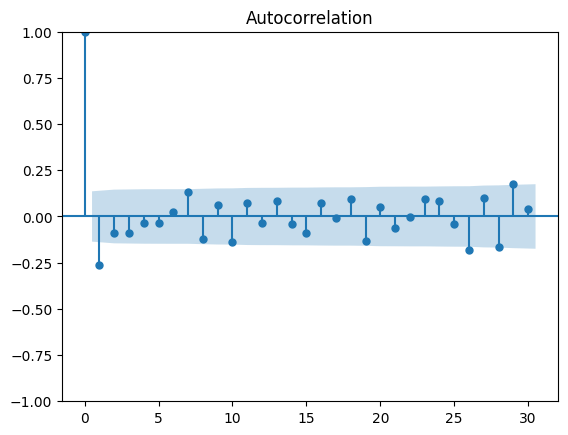

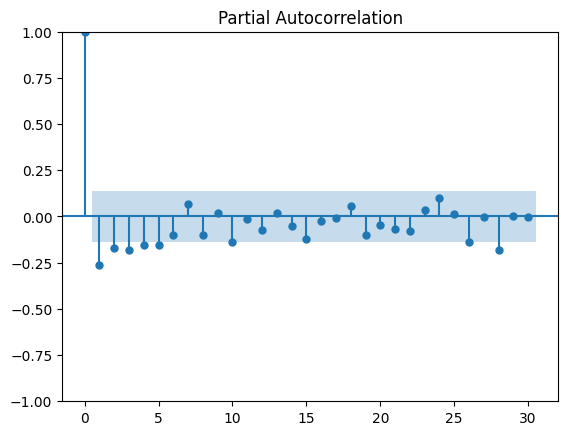

In [35]:
# Plot of ACF to understand the series 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(diff_1, lags=30)
plot_pacf(diff_1, lags=30)
plt.show()

In [36]:
# Specifying a range of parameters to determine the order using AIC
from itertools import product
ps = np.arange(0,13,1) # Order of AR
qs = np.arange(0,13,1) # Order of MA
Ps = [0] # Seasonal order of AR
Qs = [0] # Seasonal order of MA
d = 1 # one-order differencing
D = 0 # Seasonal differencing
s= 0 # period
p_q_list = list(product(ps,qs,Ps,Qs))
p_q_list[:5]

[(np.int64(0), np.int64(0), 0, 0),
 (np.int64(0), np.int64(1), 0, 0),
 (np.int64(0), np.int64(2), 0, 0),
 (np.int64(0), np.int64(3), 0, 0),
 (np.int64(0), np.int64(4), 0, 0)]

In [37]:
from tqdm import tqdm  # To show a progress bar
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function to compute AIC values for SARIMAX models
def compute_aic_values(train_s):
    """
    This function accepts a list of orders, training data, and model parameters,
    then returns the AIC values for each SARIMAX model.

    Parameters:
    - p_q_list: List of tuples containing orders (p, q, P, Q)
    - train_s: Training time series data
    - d: Non-seasonal differencing order
    - D: Seasonal differencing order
    - s: Seasonal periodicity

    Returns:
    - A DataFrame containing orders and their corresponding AIC values
    """
    aic_list = []  # Initialize an empty list to store AIC values

    for order in tqdm(p_q_list):  # Iterate over all orders in the list
        try:
            # Fit the SARIMAX model for the current order
            model = SARIMAX(
                endog=train_s,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)

            # Append the order and corresponding AIC value to the list
            aic_list.append([order, model.aic])
        except Exception as e:
            # Print detailed error message for debugging
            # print(f"Error fitting model for order {order}: {e}")
            continue

    # Convert the list of AIC values to a DataFrame
    aic_df = pd.DataFrame(aic_list, columns=['Order(p, q, Ps, Qs)', 'AIC'])

    # Sort the DataFrame by AIC values in ascending order and reset the index
    aic_df.sort_values(by='AIC', ascending=True, inplace=True)
    aic_df.reset_index(drop=True, inplace=True)

    return aic_df

In [38]:
train = weekly_accidents[['accident_count']][:-52] # 2017 to 2019
test = weekly_accidents[['accident_count']][-52:] # 2020

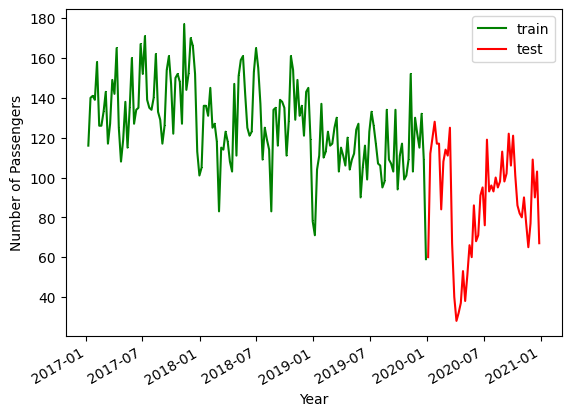

In [39]:
fig,ax = plt.subplots()

ax.plot(train,'g-,', label='train')
ax.plot(test,'r-', label='test')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Passengers')
fig.autofmt_xdate()
plt.legend()

In [40]:
aic_df = compute_aic_values(train)
aic_df

100%|██████████| 169/169 [01:43<00:00,  1.64it/s]


,"Order(p, q, Ps, Qs)",AIC
0,"(1, 1, 0, 0)",1338.357199
1,"(2, 2, 0, 0)",1339.671532
2,"(0, 2, 0, 0)",1339.752101
3,"(0, 3, 0, 0)",1340.013447
4,"(2, 1, 0, 0)",1340.204034
...,...,...
164,"(12, 10, 0, 0)",1362.151813
165,"(9, 4, 0, 0)",1363.094194
166,"(2, 0, 0, 0)",1364.285246
167,"(1, 0, 0, 0)",1369.581739


In [50]:
sarima_model = SARIMAX(endog=train, order=(1, 0, 1)).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         accident_count   No. Observations:                  156
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -680.250
Date:                Thu, 10 Apr 2025   AIC                           1366.499
Time:                        02:23:38   BIC                           1375.649
Sample:                    01-08-2017   HQIC                          1370.215
                         - 12-29-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.002    444.266      0.000       0.995       1.004
ma.L1         -0.7812      0.054    -14.342      0.000      -0.888      -0.674
sigma2       348.3633     36.005      9.675      0.000     277.794     418.932
===================================================================================
Ljung-Box (L1) (Q):                   8.26   Jarque-Bera (JB):                 6.07
Prob(Q):                              0.00   Prob(JB):                         0.05
Heteroskedasticity (H):               0.86   Skew:                            -0.37
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

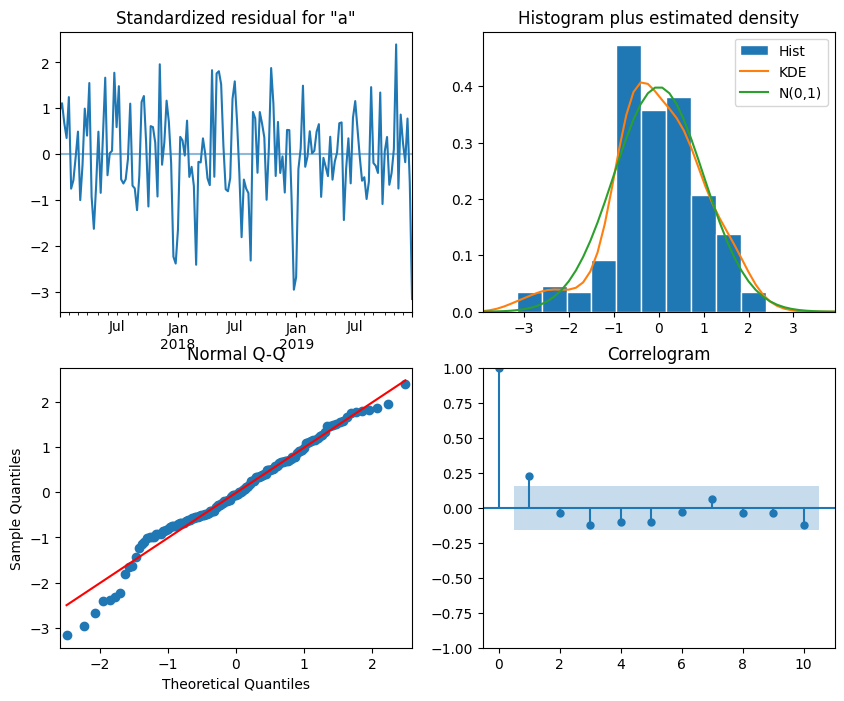

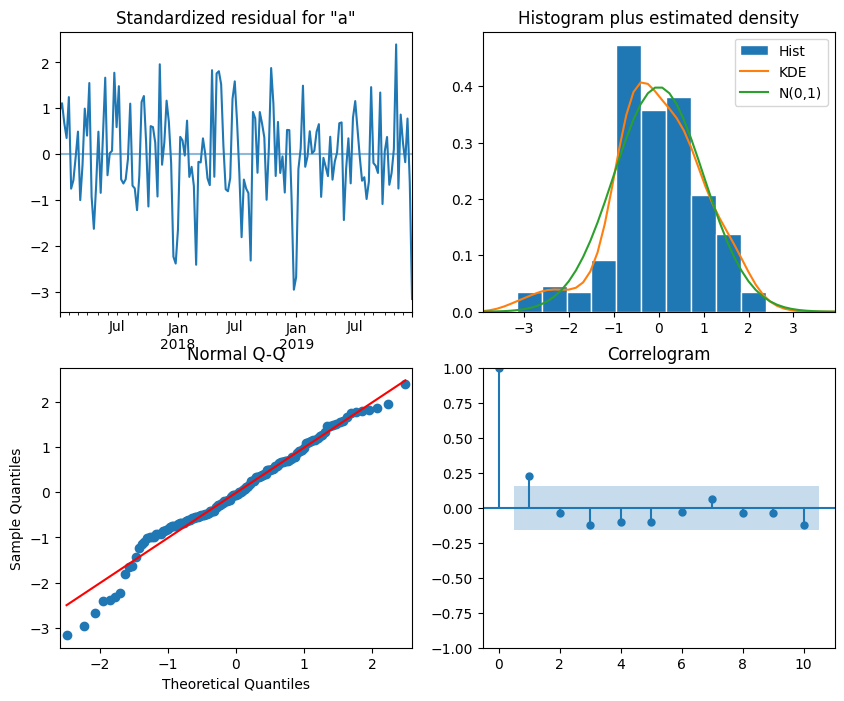

In [51]:
sarima_model.plot_diagnostics(figsize=(10, 8))

In [47]:
# Evaluation using Ljung-Box test

from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(sarima_model.resid) #returns test score for first 10 lags.

,lb_stat,lb_pvalue
1,7.951552,0.004805
2,7.965987,0.018630
3,9.118796,0.027752
4,9.452333,0.050736
5,11.140655,0.048661
6,11.398513,0.076814
7,11.753591,0.108959
8,11.799023,0.160399
9,12.318363,0.195951
10,14.189191,0.164536


In [49]:
# Get the length of the test set
len_test = len(test)

# Forecast using SARIMA model (adjust for differencing)
sarima_pred = sarima_model.get_forecast(len_test).predicted_mean.values
sarima_pred_original = sarima_pred + train['accident_count'].iloc[-1]  # Reverse differencing

# Forecast using Naive model (last values from training set)
naive_pred = train['accident_count'].iloc[-len_test:].values

# Add predictions to the test set
test['naive_pred'] = naive_pred
test['sarima_pred'] = sarima_pred_original

# Display the resulting DataFrame
print(test)

            accident_count  naive_pred  sarima_pred
date                                               
2020-01-05              60          71   164.058388
2020-01-12             112         104   163.998445
2020-01-19             120         111   163.938536
2020-01-26             128         137   163.878662
2020-02-02             117         110   163.818821
2020-02-09             117         113   163.759015
2020-02-16              84         123   163.699243
2020-02-23             108         116   163.639505
2020-03-01             114         117   163.579801
2020-03-08             111         125   163.520131
2020-03-15             125         130   163.460495
2020-03-22              67         103   163.400894
2020-03-29              40         115   163.341326
2020-04-05              28         111   163.281792
2020-04-12              32         106   163.222292
2020-04-19              37         120   163.162826
2020-04-26              53         104   163.103394
2020-05-03  

In [55]:
# Forecasting the test set using both naive_model (using the last values) and arima
len_test = len(test)

sarima_pred = sarima_model.get_forecast(len_test).predicted_mean.values

naive_pred = train['accident_count'][len(train)-52:len(train)].values
test['naive_pred'] = naive_pred
test['sarima_pred'] = sarima_pred


test

,accident_count,naive_pred,sarima_pred
date,,,
2020-01-05,60,71,105.058388
2020-01-12,112,104,104.998445
2020-01-19,120,111,104.938536
2020-01-26,128,137,104.878662
2020-02-02,117,110,104.818821
2020-02-09,117,113,104.759015
2020-02-16,84,123,104.699243
2020-02-23,108,116,104.639505
2020-03-01,114,117,104.579801


In [56]:
# Evaluation
from sklearn.metrics import root_mean_squared_error, mean_absolute_error

In [58]:
sarima_mse = mean_absolute_error(test['accident_count'],test['sarima_pred'])
naive_mse = mean_absolute_error(test['accident_count'],test['naive_pred'])

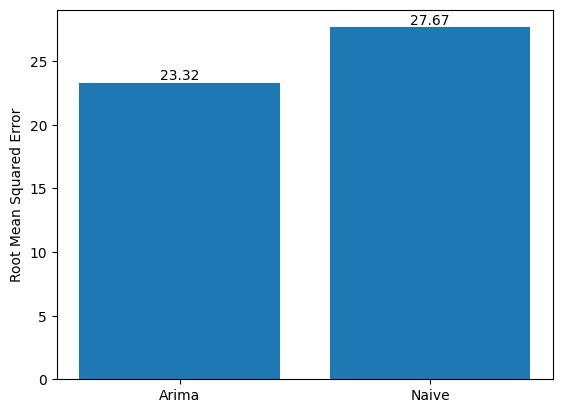

In [60]:
# Plotting the results 

list_mse = [sarima_mse,naive_mse]
models = ['Arima', 'Naive']
plt.bar(x=models,height=list_mse)
plt.ylabel('Root Mean Squared Error')

for i, value in enumerate(list_mse):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()